
# EDA and Data Cleaning

<p>Specifically targeted flights to three countries:
    <ol>
        <li>Singapore</li>
        <li>South Korea</li>
        <li>Phuket, Thailand</li>
    </ol>
From the following locations in the United States:
    <ol>
        <li>New Jersey</li>
        <li>New York</li>
        <li>California</li>
    </ol>
This was done to reduce complexity and size of the data needed for this project</p>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import calendar
import zipfile

In [2]:
def zip_to_df(zip_path):
    
    zf = zipfile.ZipFile(zip_path, mode='r')
    mdf = pd.DataFrame()
    
    # Iterate through files in zip file
    for zipfilename in zf.namelist():

        # Read contents of the file and append to mdf
        df = pd.read_csv(zf.open(zipfilename))
        df['departure_date'] = zipfilename[-28:-18]

        mdf = mdf.append(df)

    zf.close() #close zip file
    
    return mdf

def df_dict_compiler():
    # Instantiate list of all data zip files to extract
    zip_path_list = ['data/EWR_to_SIN.zip', 'data/NYC_to_SIN.zip', 'data/NYC_to_ICN.zip', 'data/SAN_to_ICN.zip',
                    'data/SAN_to_SIN.zip', 'data/EWR_to_HKT.zip']
    df_dict = {} # Dictionary used to store all the dataframes
    
    for path in zip_path_list:
        df = zip_to_df(path) # Call zip function
        df = df_cleaner(df) # Call data cleaner function
        df_dict[path[5:15]] = df
    
    return df_dict

def df_compiler():
    
    df_dict = df_dict_compiler() # Assign df_dict
    mdf = pd.DataFrame() # Instantiate a dataframe to append to
    
    # Iterate through dataframes in df_dict
    for df in df_dict.values():
        mdf = mdf.append(df) # Append each dataframe to mdf
    
    mdf.drop_duplicates(inplace=True) # Remove any duplicates
    return mdf

In [3]:
def total_duration(df):
    
    out_total = []
    ret_total = []
    
    for dur in df['Out Duration']:
        hr = int(dur.split('h')[0]) * 60
        m = int(dur.split('h')[1][:-1])
        total = hr + m
        out_total.append(total)

    for dur in df['Return Duration']:
        hr = int(dur.split('h')[0]) * 60
        m = int(dur.split('h')[1][:-1])
        total = hr + m
        ret_total.append(total)
        
    df['total_duration'] = pd.Series(out_total) + pd.Series(ret_total)
    
    return df

def dep_ret_time(df):
    
    dep_times = [time.split(' ')[0] for time in df['Out Time']]
    ret_times = [time.split(' ')[0] for time in df['Return Time']]
    record_time = [time.split('-')[1][:2] for time in df['timestamp']]
    
    df['dep_time'] = pd.Series(dep_times)
    df['ret_time'] = pd.Series(ret_times)
    df['record_time'] = pd.Series(record_time)
    
    return df

def dep_ret_airline(df):

    dep_air = [airline.split(',')[0] for airline in df['Out Airline']]
    ret_air = [airline.split(',')[0] for airline in df['Return Airline']]
    
    df['dep_airline'] = pd.Series(dep_air)
    df['ret_airline'] = pd.Series(ret_air)
    
    return df

def name_date_extractor(df):
    
    dep_day = [calendar.day_name[pd.to_datetime(date).weekday()] for date in df['departure_date']]
    search_day = [calendar.day_name[pd.to_datetime(date).weekday()] for date in df['timestamp']]

    df['departure_day'] = pd.Series(dep_day)
    df['search_day'] = pd.Series(search_day)
    
    return df

# def target_assigner(df, price_per, duration_per):
def target_assigner(df):
    
    min_price = df['Price'].min()

    mid_price = df['Price'].describe()['25%']
    mid_duration = df['total_duration'].describe()['25%']
    
#     mid_price = df['Price'].describe()[price_per]
#     mid_duration = df['total_duration'].describe()[duration_per]

    df['target'] = np.where( ( (df['Price'] < mid_price) & (df['total_duration'] < mid_duration) ), 1, 0)
    
    return df

def df_cleaner(df):
    
    df_duration = total_duration(df)
    
    df_times = dep_ret_time(df_duration)
    
    df_airlines = dep_ret_airline(df_times)
    
    df_date_names = name_date_extractor(df_airlines)
    
    df_date_names['total_stops'] = df['Out Stops'] + df['Return Stops']
    
    dfc = target_assigner(df_date_names)
    
    return dfc

In [4]:
df = df_compiler()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22964 entries, 0 to 45
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Out Time            22964 non-null  object
 1   Out Airline         22964 non-null  object
 2   Out Cities          22964 non-null  object
 3   Out Duration        22964 non-null  object
 4   Out Stops           22964 non-null  int64 
 5   Out Stop Cities     19899 non-null  object
 6   Return Time         22964 non-null  object
 7   Return Airline      22964 non-null  object
 8   Return Cities       22964 non-null  object
 9   Return Duration     22964 non-null  object
 10  Return Stops        22964 non-null  int64 
 11  Return Stop Cities  20009 non-null  object
 12  Price               22964 non-null  int64 
 13  timestamp           22964 non-null  object
 14  sort                22964 non-null  object
 15  departure_date      22964 non-null  object
 16  total_duration      22964

In [5]:
df['target'].value_counts(normalize=True)

0    0.977487
1    0.022513
Name: target, dtype: float64

In [6]:
df['record_time'].value_counts()

06    10425
07     5048
12     3934
14     3557
Name: record_time, dtype: int64

In [7]:
df.head()

,Out Time,Out Airline,Out Cities,Out Duration,Out Stops,Out Stop Cities,Return Time,Return Airline,Return Cities,Return Duration,...,total_duration,dep_time,ret_time,record_time,dep_airline,ret_airline,departure_day,search_day,total_stops,target
0,8:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,27h40m,2,"ATL, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,3245,8:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
1,9:00 am – 11:40 pm +1,Korean Air,EWR‐SIN,26h40m,2,"BOS, ICN",1:10 am – 3:35 pm,Korean Air,SIN‐EWR,26h25m,...,3185,9:00,1:10,14,Korean Air,Korean Air,Sunday,Sunday,4,0
2,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,2860,11:25,6:10,14,ANA,ANA,Sunday,Sunday,2,1
3,6:30 am – 12:35 am +2,ANA,EWR‐SIN,30h05m,2,"LAX, NRT",6:10 am – 4:40 pm,ANA,SIN‐EWR,22h30m,...,3155,6:30,6:10,14,ANA,ANA,Sunday,Sunday,3,0
4,11:25 am – 12:35 am +2,ANA,EWR‐SIN,25h10m,1,NRT,10:10 pm – 9:27 pm +1,ANA,SIN‐EWR,35h17m,...,3627,11:25,10:10,14,ANA,ANA,Sunday,Sunday,3,0


In [8]:
for col in df.columns:
    # Select the column by name and get count of unique values in it
    count = df[col].nunique()
    print(f'Count of Unique values in Column "{col}" is: {count}')

Count of Unique values in Column "Out Time" is: 1128
Count of Unique values in Column "Out Airline" is: 129
Count of Unique values in Column "Out Cities" is: 9
Count of Unique values in Column "Out Duration" is: 533
Count of Unique values in Column "Out Stops" is: 4
Count of Unique values in Column "Out Stop Cities" is: 259
Count of Unique values in Column "Return Time" is: 1332
Count of Unique values in Column "Return Airline" is: 151
Count of Unique values in Column "Return Cities" is: 10
Count of Unique values in Column "Return Duration" is: 838
Count of Unique values in Column "Return Stops" is: 4
Count of Unique values in Column "Return Stop Cities" is: 244
Count of Unique values in Column "Price" is: 2703
Count of Unique values in Column "timestamp" is: 1395
Count of Unique values in Column "sort" is: 3
Count of Unique values in Column "departure_date" is: 91
Count of Unique values in Column "total_duration" is: 171
Count of Unique values in Column "dep_time" is: 60
Count of Uniq

In [9]:
# for dur in tdf['Out Duration']:
#     hr = int(dur.split('h')[0]) * 60
#     m = int(dur.split('h')[1][:-1])
#     total = hr + m
    
#     formated = str(f'{total//60}h{total%60}m')
#     print(total, formated)

In [10]:
# zf.namelist()[0][-28:-18]
# zf.namelist()[0][-23:-18]

---

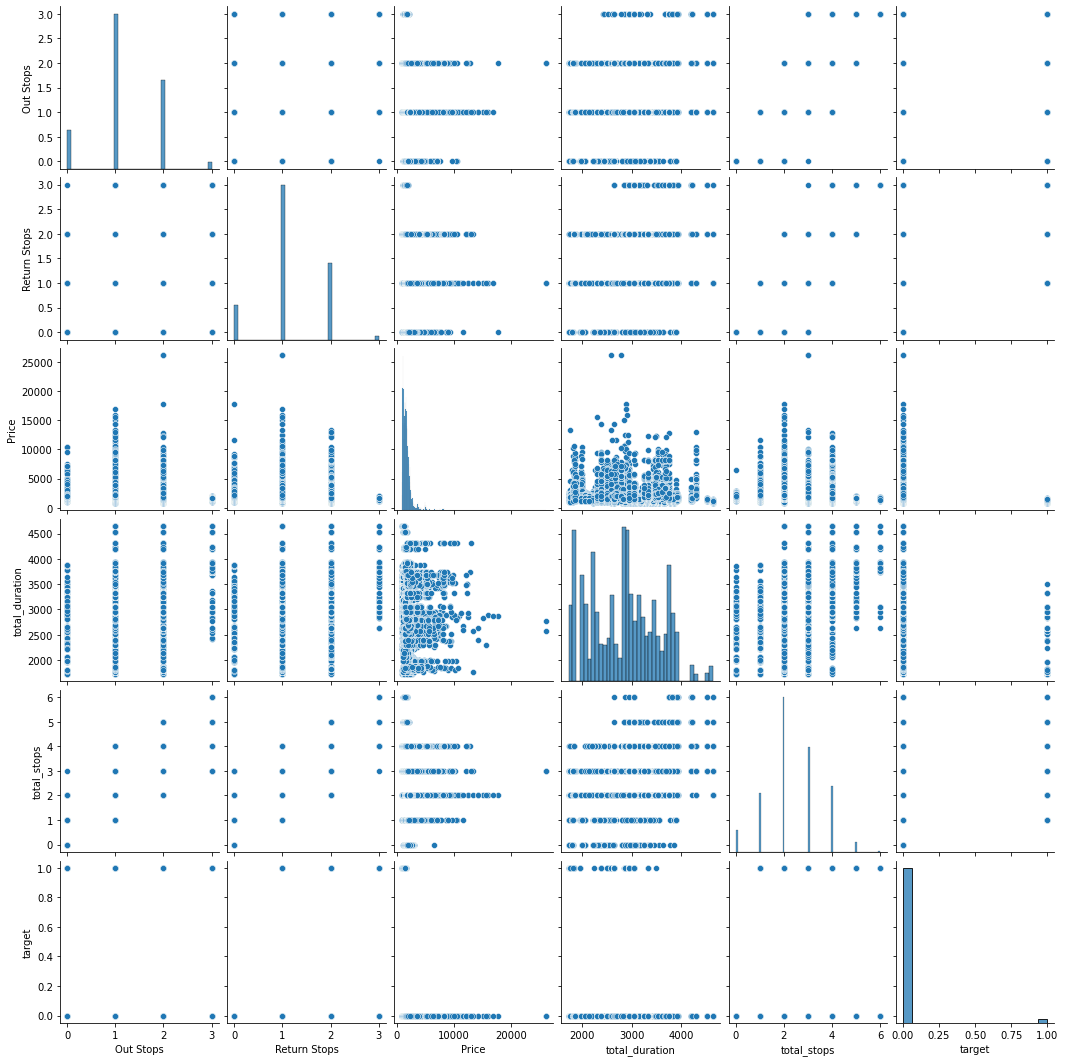

In [11]:
sns.pairplot(df);

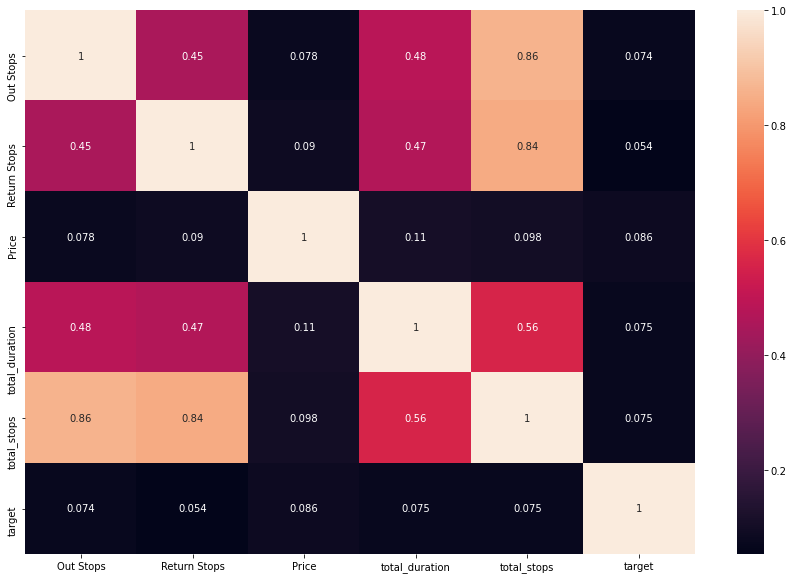

In [12]:
plt.figure(figsize = (15, 10))
sns.heatmap(df.corr().abs(), annot = True);

In [13]:
time_df = df.set_index(pd.to_datetime(df['departure_date']), drop=True)
ts_price = time_df['Price']

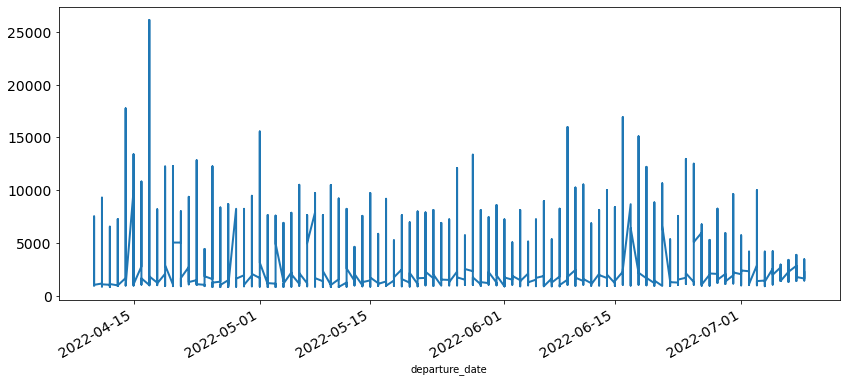

In [14]:
ts_price.plot(figsize=(14,6), linewidth=2, fontsize=14);

In [15]:
# importing relevant library
from statsmodels.tsa.stattools import adfuller

# For testing stationarity
def dicky_fuller(ts):
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(
                    dftest[0:4], 
                    index=['Test Statistic','p-value','#Lags Used','Number of Observations Used']
    )

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    alpha = 0.05
    is_stationary = dftest[1] < alpha
    if is_stationary == True:
        print(f'The data is stationary with a fuller score of {round(dftest[1],3)}')
    else:
        print(f'The data is not stationary with a fuller score of {round(dftest[1],3)}')
        
    display(dfoutput)

In [16]:
dicky_fuller(ts)

NameError: name 'ts' is not defined

In [ ]:
df.to_csv('data/masterdf.csv', index=False) 

In [ ]:
df = pd.read_csv('data/masterdf.csv')
df.head()